In [1]:
import pandas as pd
import numpy as np
from utils import *
import pytensor.tensor as pt  # Import PyTensor (Theano backend)

In [2]:
df = read_dd_data('../data/PD_data')
df

,rcert,runcert,event_prob,choice,condition,rt,odds,participant
0,5.0,9.50,0.10,0.0,1.0,2013.5,9.000000,bh348lli7
1,10.0,11.11,0.90,0.0,1.0,514.4,0.111111,bh348lli7
2,1.0,1.10,0.50,0.0,1.0,424.2,1.000000,bh348lli7
3,1.0,31.00,0.25,0.0,1.0,398.2,3.000000,bh348lli7
4,20.0,80.00,0.50,0.0,1.0,538.3,1.000000,bh348lli7
...,...,...,...,...,...,...,...,...
9795,-10.0,-100.00,0.10,0.0,2.0,1504.1,9.000000,u3yyfob1i
9796,-10.0,-40.00,0.25,1.0,2.0,1856.4,3.000000,u3yyfob1i
9797,-5.0,-9.50,0.10,1.0,2.0,1911.6,9.000000,u3yyfob1i
9798,-50.0,-100.00,0.75,0.0,2.0,2848.4,0.333333,u3yyfob1i


In [3]:
print(df.isna().sum())  # Check for NaNs

rcert          0
runcert        0
event_prob     0
choice         0
condition      0
rt             0
odds           0
participant    0
dtype: int64


Number of participants: 49
Average trials per participant: 198.96
Min trials: 192
Max trials: 200


<Axes: >

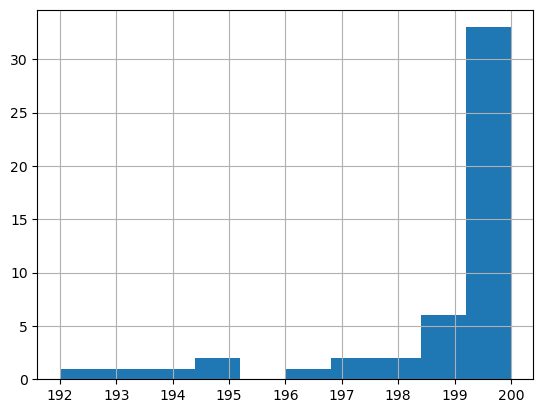

In [4]:
# print number of participants
print(f"Number of participants: {df['participant'].nunique()}")

# Calculate trials per participant
trials_per_participant = df.groupby('participant').size()
print(f"Average trials per participant: {trials_per_participant.mean():.2f}")
print(f"Min trials: {trials_per_participant.min()}")
print(f"Max trials: {trials_per_participant.max()}")

trials_per_participant.hist()

In [5]:
# Extract participant information
participants = df["participant"].unique()
n_participants = len(participants)

# Convert participant IDs to integer indices
participant_idx = {pid: i for i, pid in enumerate(participants)}
df["participant_idx"] = df["participant"].map(participant_idx)

'''
Because of the different levels of magnitude
we decide to standarize rewards and reaction times
'''

# used later for unscaling
scaling_factors = {
    "rt_mean": df['rt'].mean(), "rt_std": df['rt'].std(),
    "rcert_mean": df['rcert'].mean(), "rcert_std": df['rcert'].std(),
    "runcert_mean": df['runcert'].mean(), "runcert_std": df['runcert'].std()
}

df["rcert"] = (df["rcert"] - scaling_factors["rcert_mean"]) / scaling_factors["rcert_std"]
df["runcert"] = (df["runcert"] - scaling_factors["runcert_mean"]) / scaling_factors["runcert_std"]
df["rt"] = (df["rt"] - scaling_factors["rt_mean"]) / scaling_factors["rt_std"]

df.describe()

,rcert,runcert,event_prob,choice,condition,rt,odds,participant_idx
count,9.749000e+03,9.749000e+03,9749.000000,9749.000000,9749.000000,9.749000e+03,9749.000000,9749.000000
mean,-1.494115e-17,-5.284065e-18,0.500164,0.393887,1.498513,5.247623e-17,2.690339,24.001026
std,1.000000e+00,1.000000e+00,0.298548,0.488635,0.500023,1.000000e+00,3.318231,14.143768
min,-2.037028e+00,-8.083318e+00,0.100000,0.000000,1.000000,-1.608896e+00,0.111111,0.000000
25%,-4.096258e-01,-5.042424e-02,0.250000,0.000000,1.000000,-6.734468e-01,0.333333,12.000000
50%,3.790984e-02,1.109205e-03,0.500000,0.000000,1.000000,-2.283195e-01,1.000000,24.000000
75%,4.040754e-01,5.438353e-02,0.750000,1.000000,2.000000,4.359645e-01,3.000000,36.000000
max,2.031478e+00,8.081948e+00,0.900000,1.000000,2.000000,5.155760e+00,9.000000,48.000000


In [6]:
# Create train/test split by dropping 20% of trials per participant
test_indices = []

for participant in df['participant'].unique():
    participant_data = df[df['participant'] == participant]
    n_trials = len(participant_data)
    n_test = int(0.2 * n_trials)  # 20% of trials
    
    # Randomly sample indices for test set
    participant_test_indices = participant_data.sample(n=n_test).index
    test_indices.extend(participant_test_indices)

# Create train and test dataframes
df_test = df.loc[test_indices].copy()
df_train = df.drop(test_indices).copy()

print(f"Train set size: {len(df_train)} trials")
print(f"Test set size: {len(df_test)} trials")
print(f"Test set percentage: {(len(df_test) / len(df)) * 100:.1f}%")


Train set size: 7808 trials
Test set size: 1941 trials
Test set percentage: 19.9%


In [7]:
df_test

,rcert,runcert,event_prob,choice,condition,rt,odds,participant,participant_idx
195,-0.816476,-1.102055,0.25,0.0,2.0,-1.563632,3.000000,bh348lli7,0
46,2.031478,0.176955,0.75,0.0,1.0,-0.586605,0.333333,bh348lli7,0
148,0.810926,0.066818,0.10,0.0,1.0,-1.585812,9.000000,bh348lli7,0
131,0.810926,0.036033,0.75,0.0,1.0,-1.446892,0.333333,bh348lli7,0
36,2.031478,0.354596,0.50,0.0,1.0,-1.464970,1.000000,bh348lli7,0
...,...,...,...,...,...,...,...,...,...
9763,-0.043460,-0.002994,0.25,0.0,2.0,-0.741029,3.000000,u3yyfob1i,48
9716,0.810926,0.046692,0.90,1.0,1.0,-1.044803,0.111111,u3yyfob1i,48
9762,-0.043460,-0.018449,0.25,1.0,2.0,-1.170513,3.000000,u3yyfob1i,48
9770,-0.816476,-0.036604,0.90,0.0,2.0,-0.582016,0.111111,u3yyfob1i,48


In [8]:
df_train

,rcert,runcert,event_prob,choice,condition,rt,odds,participant,participant_idx
0,0.200650,0.016191,0.10,0.0,1.0,-0.347980,9.000000,bh348lli7,0
1,0.404075,0.019051,0.90,0.0,1.0,-1.390295,0.111111,bh348lli7,0
2,0.037910,0.001269,0.50,0.0,1.0,-1.453011,1.000000,bh348lli7,0
3,0.037910,0.054384,0.25,0.0,1.0,-1.471088,3.000000,bh348lli7,0
4,0.810926,0.141427,0.50,0.0,1.0,-1.373678,1.000000,bh348lli7,0
...,...,...,...,...,...,...,...,...,...
9794,-2.037028,-2.754109,0.25,1.0,2.0,-0.926117,3.000000,u3yyfob1i,48
9796,-0.409626,-0.071741,0.25,1.0,2.0,-0.457210,3.000000,u3yyfob1i,48
9797,-0.206201,-0.017561,0.10,1.0,2.0,-0.418830,9.000000,u3yyfob1i,48
9798,-2.037028,-0.178325,0.75,0.0,2.0,0.232521,0.333333,u3yyfob1i,48


In [9]:
df = df_train

In [10]:
'''
TODOS:

- loss ul fluctueaza de la 50 la 3e+11.
- change sigma for k, beta, beta0 and beta1 as deterministic, like in the slides
'''

'\nTODOS:\n\n- loss ul fluctueaza de la 50 la 3e+11.\n- change sigma for k, beta, beta0 and beta1 as deterministic, like in the slides\n'

In [11]:
# Extract observed data
rcert = df["rcert"].values
runcert = df["runcert"].values
event_prob = df["event_prob"].values
choice_data = df["choice"].astype(int).values  # Ensure it's an integer for Bernoulli
rt_data = df["rt"].values
participant_ids = df["participant_idx"].values  # Integer IDs

# Define hierarchical PyMC model
with pm.Model() as model:
    # Group-level priors

    # mu_k = pm.Normal("mu_k", mu=0, sigma=1)  
    # sigma_k = pm.HalfNormal("sigma_k", sigma=1)  

    mu_k = pm.Normal("mu_k", mu=0, sigma=1)
    sigma_k_raw = pm.Normal("sigma_k_raw", mu=0, sigma=1)
    sigma_k = pm.Deterministic("sigma_k", pm.math.exp(sigma_k_raw))
    
    # beta i.e. sensitivity needs to be strictly positive
    mu_beta = pm.HalfNormal("mu_beta", sigma=1)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=1)

    # since we work with normalized reaction times this can be negative as well
    mu_beta0 = pm.Normal("mu_beta0", mu=0, sigma=1)
    sigma_beta0 = pm.HalfNormal("sigma_beta0", sigma=1)

    # beta1 i.e. sensitivity needs to be strictly positive
    mu_beta1 = pm.HalfNormal("mu_beta1", sigma=1)
    sigma_beta1 = pm.HalfNormal("sigma_beta1", sigma=1)

    # sigma for RT needs to be strictly positive
    mu_sigma_RT = pm.HalfNormal("mu_sigma_RT", sigma=1)
    sigma_sigma_RT = pm.HalfNormal("sigma_sigma_RT", sigma=1)

    # Participant-level parameters (hierarchical structure)
    # k = pm.Lognormal("k", mu=mu_k, sigma=sigma_k, shape=n_participants)
    k_raw = pm.Normal("k_raw", mu=0, sigma=1, shape=n_participants)
    k = pm.Deterministic("k", pm.math.exp(mu_k + sigma_k * k_raw))

    beta = pm.Lognormal("beta", mu=mu_beta, sigma=sigma_beta, shape=n_participants)
    beta0 = pm.Normal("beta0", mu=mu_beta0, sigma=sigma_beta0, shape=n_participants)
    beta1 = pm.LogNormal("beta1", mu=mu_beta1, sigma=sigma_beta1, shape=n_participants)

    # Compute subjective values using hyperbolic discounting
    SV_certain = rcert
    SV_uncertain = runcert / (1 + k[participant_ids] * event_prob)

    # Choice model (Bernoulli with logistic function)
    max_exp = 10
    # TODO: slide 36 of lecture 4 she uses the oposite difference
    exp = beta[participant_ids] * (SV_uncertain - SV_certain) # TODO: check order of SV_uncertain and SV_certain
    exp = pm.math.clip(exp, -max_exp, max_exp)

    prob_choose_uncertain = pm.Deterministic("prob_choose_uncertain",
        pm.math.sigmoid(exp) 
    )
    choice = pm.Bernoulli("choice", p=prob_choose_uncertain, observed=choice_data)

    # Reaction time model (log-normal)
    decision_difficulty = (SV_uncertain - SV_certain) ** 2
    mu_RT = pm.Deterministic("mu_RT", beta0[participant_ids] + beta1[participant_ids] * decision_difficulty)
   
    # NOTE: remember we are using log RTs not the actual RTs
    # TODO: here we need a trainable sigma not a constant one
    sigma_RT = pm.Lognormal("sigma_RT", mu=mu_sigma_RT, sigma=sigma_sigma_RT, shape=n_participants)
    log_RT = pm.Normal("log_RT", mu=mu_RT, sigma=sigma_RT[participant_ids], observed=rt_data)

    model.debug(verbose=True)

    # Run sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.90, return_inferencedata=True, init='jitter+adapt_diag')
    # trace = pm.sample(draws=5, tune =0, chains=1, progressbar=False)

# Save trace to disk
trace.to_netcdf("probabilistic_discounting_trace.nc")


point={'mu_k': array(0.), 'sigma_k_raw': array(0.), 'mu_beta_log__': array(0.), 'sigma_beta_log__': array(0.), 'mu_beta0': array(0.), 'sigma_beta0_log__': array(0.), 'mu_beta1_log__': array(0.), 'sigma_beta1_log__': array(0.), 'mu_sigma_RT_log__': array(0.), 'sigma_sigma_RT_log__': array(0.), 'k_raw': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'beta_log__': array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]), 'beta0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.,

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_k, sigma_k_raw, mu_beta, sigma_beta, mu_beta0, sigma_beta0, mu_beta1, sigma_beta1, mu_sigma_RT, sigma_sigma_RT, k_raw, beta, beta0, beta1, sigma_RT]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 282 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


'probabilistic_discounting_trace.nc'

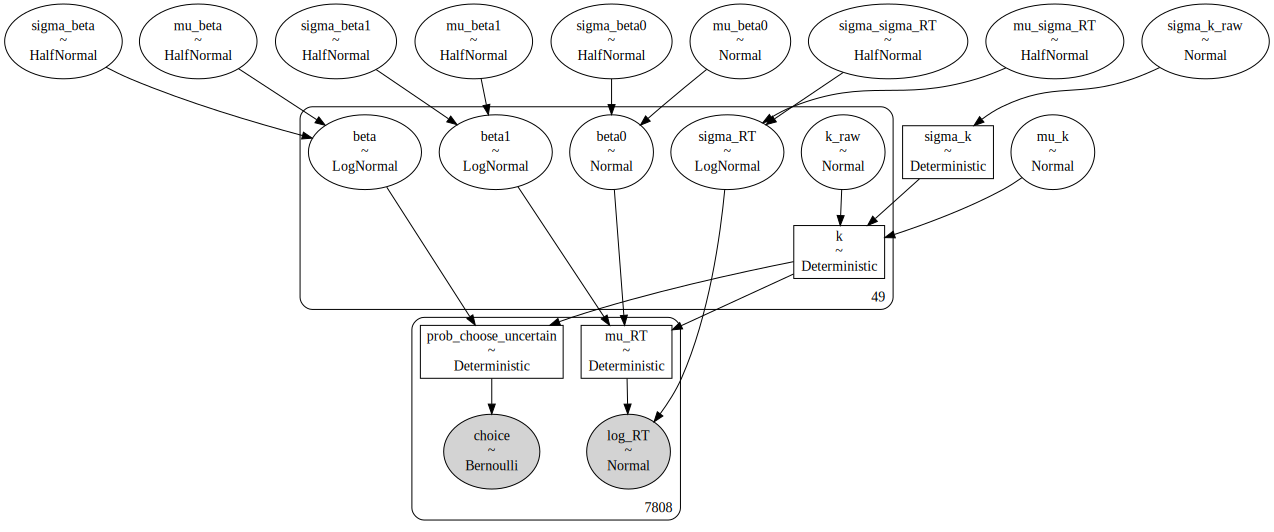

In [12]:
pm.model_to_graphviz(model)


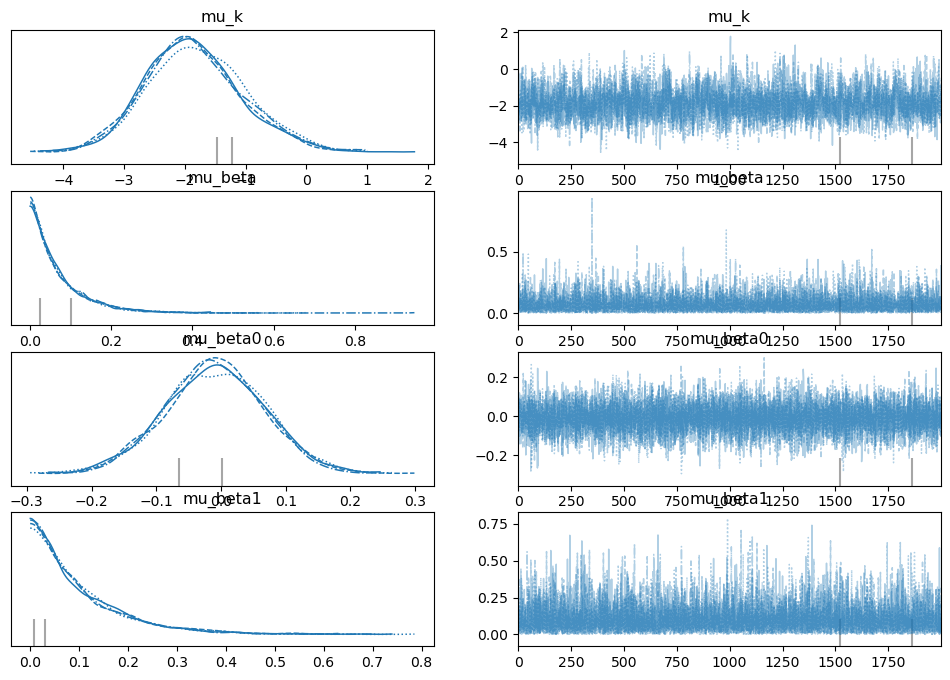

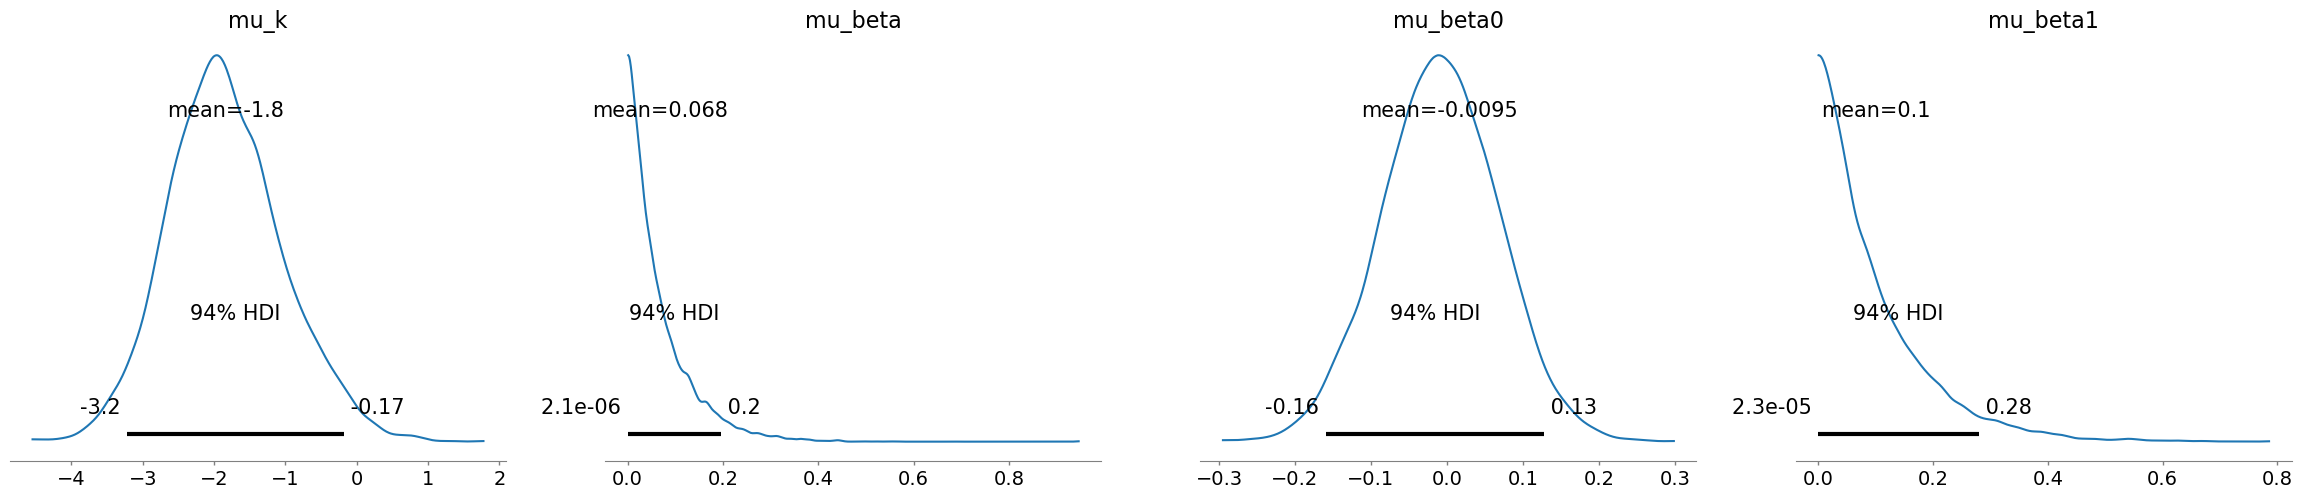

Effective Sample Size (ESS) per parameter:
 <xarray.Dataset> Size: 255kB
Dimensions:                      (k_raw_dim_0: 49, beta0_dim_0: 49,
                                  beta_dim_0: 49, beta1_dim_0: 49,
                                  sigma_RT_dim_0: 49, k_dim_0: 49,
                                  prob_choose_uncertain_dim_0: 7808,
                                  mu_RT_dim_0: 7808)
Coordinates:
  * k_raw_dim_0                  (k_raw_dim_0) int64 392B 0 1 2 3 ... 46 47 48
  * beta0_dim_0                  (beta0_dim_0) int64 392B 0 1 2 3 ... 46 47 48
  * beta_dim_0                   (beta_dim_0) int64 392B 0 1 2 3 ... 45 46 47 48
  * beta1_dim_0                  (beta1_dim_0) int64 392B 0 1 2 3 ... 46 47 48
  * sigma_RT_dim_0               (sigma_RT_dim_0) int64 392B 0 1 2 ... 46 47 48
  * k_dim_0                      (k_dim_0) int64 392B 0 1 2 3 4 ... 45 46 47 48
  * prob_choose_uncertain_dim_0  (prob_choose_uncertain_dim_0) int64 62kB 0 ....
  * mu_RT_dim_0                

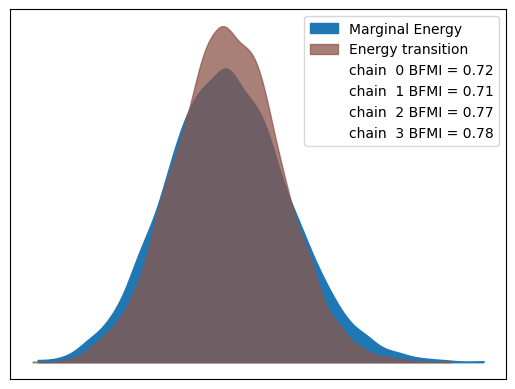

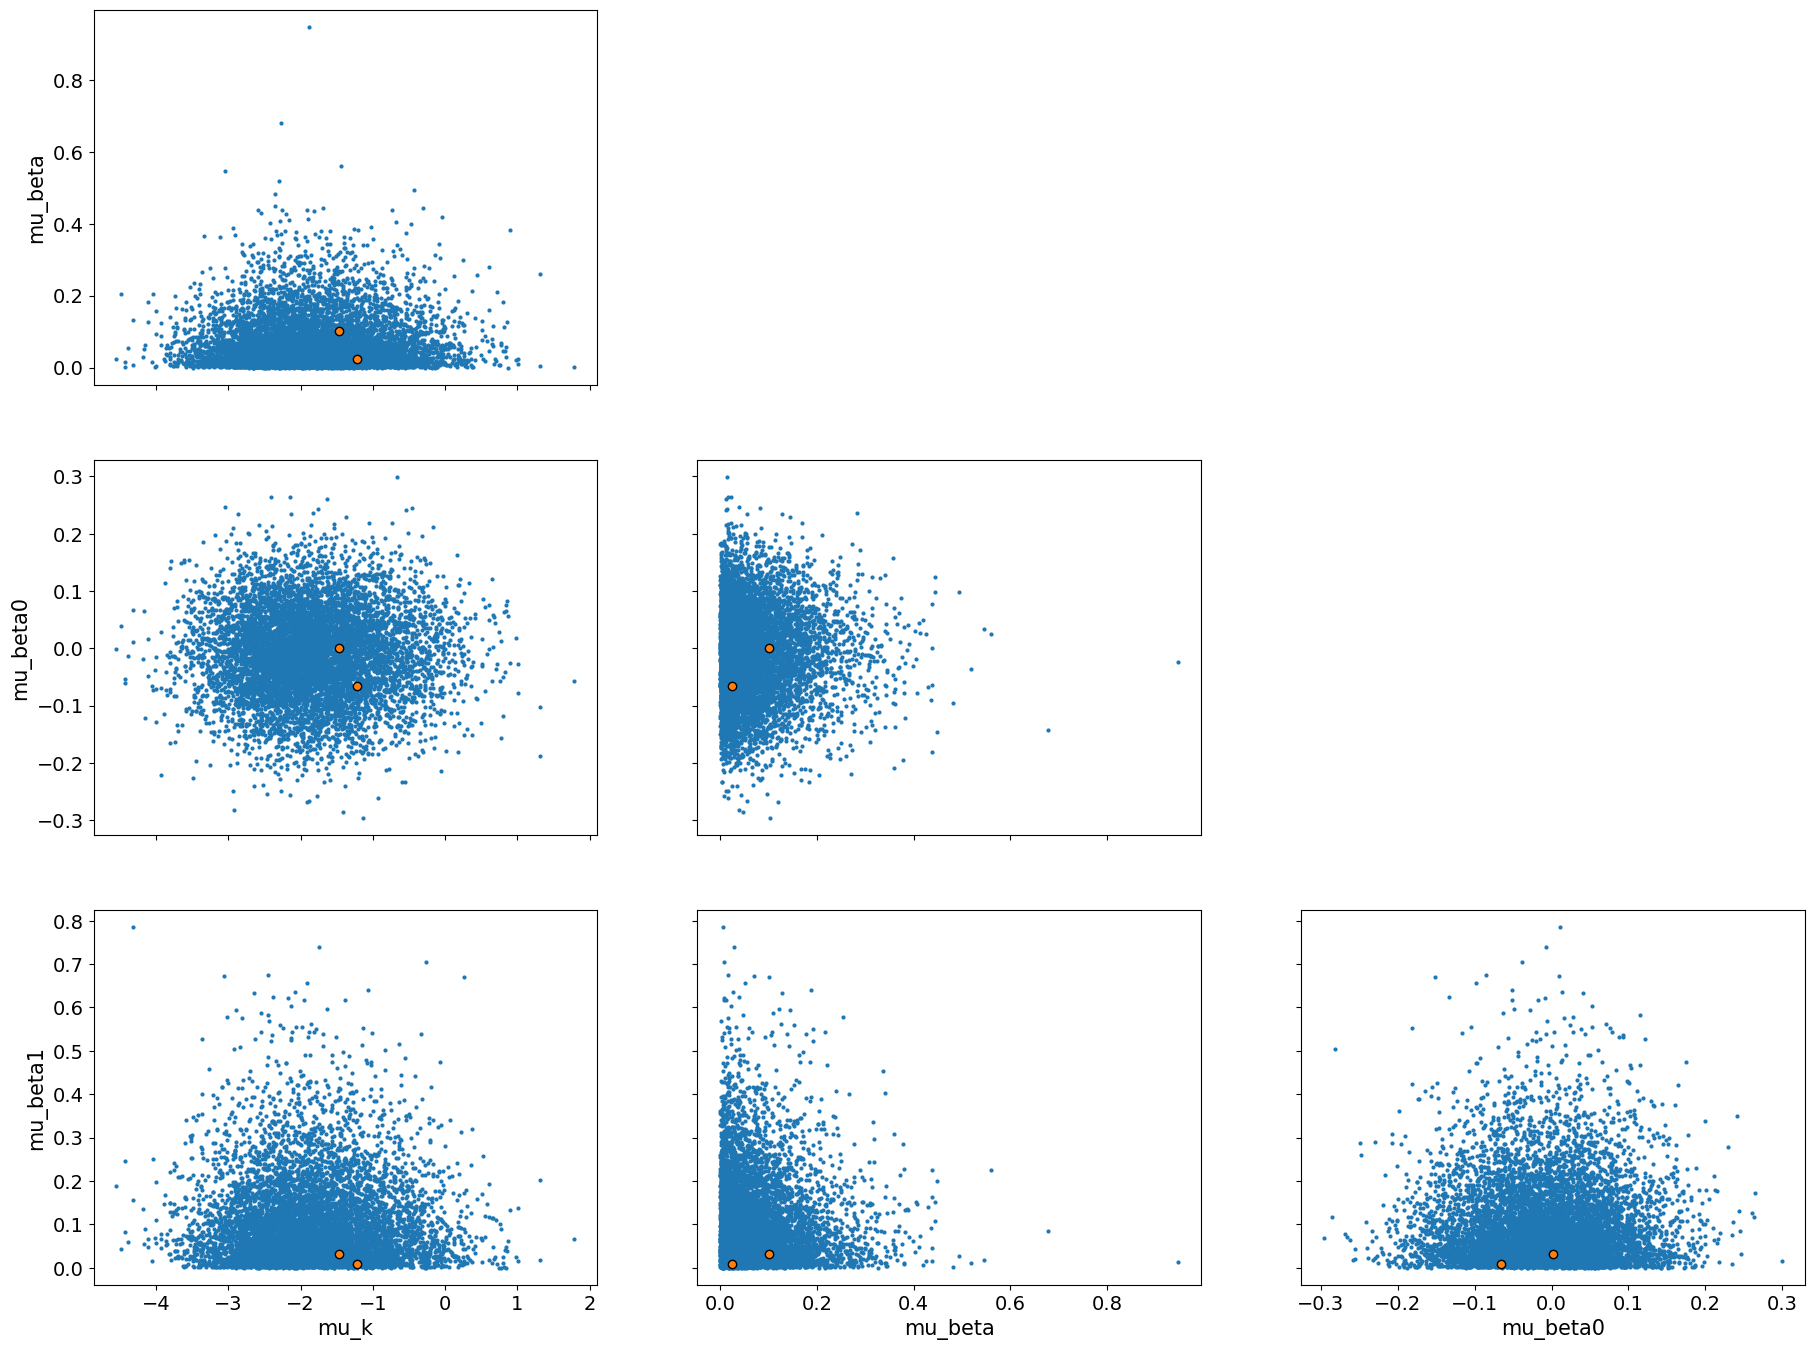

In [13]:
import arviz as az
import matplotlib.pyplot as plt

# Load the saved trace from disk
trace = az.from_netcdf("probabilistic_discounting_trace.nc")

# Trace plot: Check parameter convergence across chains
az.plot_trace(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"])

plt.show()

# Posterior distributions: Check inferred parameter values
az.plot_posterior(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"])
plt.show()

# Check effective sample size (ESS): Should be > 200 per chain
ess_values = az.ess(trace)
print("Effective Sample Size (ESS) per parameter:\n", ess_values)

# Energy plot: Helps diagnose divergences
az.plot_energy(trace)
plt.show()

# Pair plot for key parameters (shows correlation structure)
az.plot_pair(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"], kind="scatter", divergences=True)
plt.show()

In [14]:
def check_convergence_rhat(trace, threshold=1.05):
    """
    Check convergence of all parameters using R-hat values.
    
    Args:
        trace: ArviZ InferenceData object
        threshold: R-hat threshold for convergence warning (default: 1.05)
    """
    rhat_values = az.rhat(trace)
    
    # Define parameter groups for organized output
    param_groups = {
        "Group-level means": ["mu_k", "mu_beta", "mu_beta0", "mu_beta1", "mu_sigma_RT"],
        "Group-level standard deviations": ["sigma_k", "sigma_beta", "sigma_beta0", "sigma_beta1", "sigma_sigma_RT"],
        "Individual-level parameters": ["k", "beta", "beta0", "beta1", "sigma_RT"],
        "Deterministic variables": ["prob_choose_uncertain", "mu_RT"]
    }
    
    print("=== Convergence Analysis (R-hat) ===\n")
    
    all_good = True
    problematic_params = []
    
    for group_name, params in param_groups.items():
        print(f"\n{group_name}:")
        print("-" * (len(group_name) + 1))
        
        for param in params:
            if param in rhat_values.data_vars:
                values = rhat_values[param].values
                
                # For scalar parameters
                if np.size(values) == 1:
                    status = "✓" if values < threshold else "⚠️"
                    print(f"{status} {param}: {float(values):.3f}")
                    if values >= threshold:
                        all_good = False
                        problematic_params.append(f"{param} ({float(values):.3f})")
                
                # For vector parameters
                else:
                    max_rhat = np.max(values)
                    mean_rhat = np.mean(values)
                    status = "✓" if max_rhat < threshold else "⚠️"
                    print(f"{status} {param}:")
                    print(f"    mean: {mean_rhat:.3f}")
                    print(f"    max:  {max_rhat:.3f}")
                    print(f"    min:  {np.min(values):.3f}")
                    if max_rhat >= threshold:
                        all_good = False
                        problematic_params.append(f"{param} (max: {max_rhat:.3f})")
            else:
                print(f"⚪ {param}: Not found in trace")
    
    print("\n=== Summary ===")
    if all_good:
        print("✅ All parameters show good convergence (R-hat < 1.05)")
    else:
        print("❌ Convergence issues detected!")
        print("\nParameters requiring attention:")
        for param in problematic_params:
            print(f"  - {param}")
# Usage
check_convergence_rhat(trace)

=== Convergence Analysis (R-hat) ===


Group-level means:
------------------
✓ mu_k: 1.005
✓ mu_beta: 1.000
✓ mu_beta0: 1.001
✓ mu_beta1: 1.000
✓ mu_sigma_RT: 1.000

Group-level standard deviations:
--------------------------------
✓ sigma_k: 1.008
✓ sigma_beta: 1.003
✓ sigma_beta0: 1.000
✓ sigma_beta1: 1.002
✓ sigma_sigma_RT: 1.000

Individual-level parameters:
----------------------------
✓ k:
    mean: 1.004
    max:  1.007
    min:  1.001
✓ beta:
    mean: 1.001
    max:  1.004
    min:  1.000
✓ beta0:
    mean: 1.001
    max:  1.003
    min:  1.000
✓ beta1:
    mean: 1.001
    max:  1.005
    min:  1.000
✓ sigma_RT:
    mean: 1.001
    max:  1.002
    min:  1.000

Deterministic variables:
------------------------
✓ prob_choose_uncertain:
    mean: 1.001
    max:  1.008
    min:  1.000
✓ mu_RT:
    mean: 1.001
    max:  1.003
    min:  1.000

=== Summary ===
✅ All parameters show good convergence (R-hat < 1.05)


=== Model Evaluation on Test Data ===

Choice Predictions:
Accuracy: 0.493
Log Likelihood: -0.703

Reaction Time Predictions:
RMSE: 2044.482
R²: -1.065


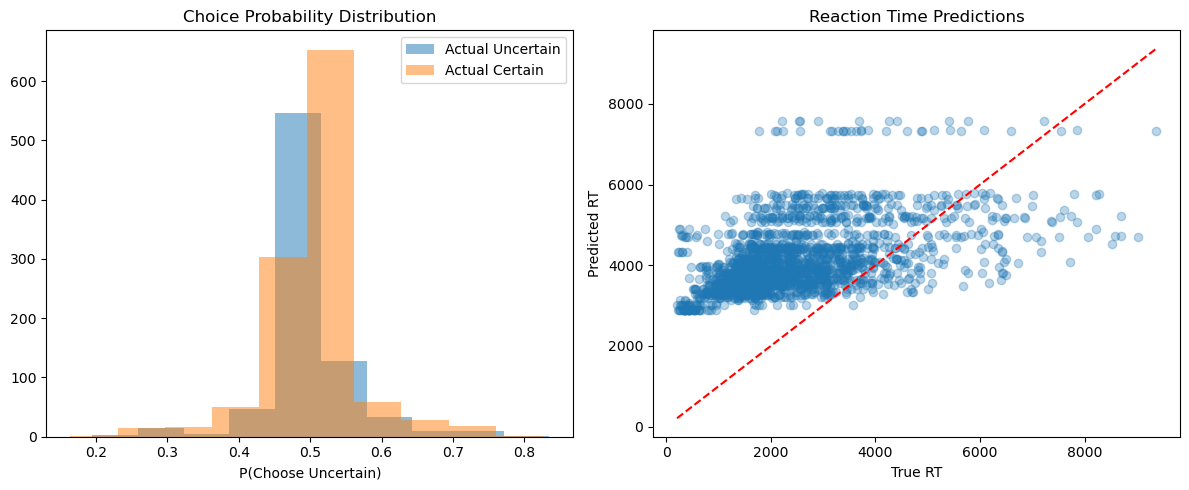

In [18]:
def evaluate_model_predictions(trace, df_test, scaling_factors):
    """
    Evaluate model predictions on test data for both choices and reaction times.
    
    Args:
        trace: ArviZ InferenceData object with the fitted model
        df_test: DataFrame with test data
        scaling_factors: Dictionary with scaling factors used for normalization
    """
    # Extract posterior samples
    posterior = trace.posterior

    # get scaling factors
    rcert_mean = scaling_factors["rcert_mean"]
    rcert_std = scaling_factors["rcert_std"]
    runcert_mean = scaling_factors["runcert_mean"]
    runcert_std = scaling_factors["runcert_std"]
    rt_mean = scaling_factors["rt_mean"]
    rt_std = scaling_factors["rt_std"]
    
    # Prepare test data
    rcert = df_test["rcert"].values
    runcert = df_test["runcert"].values
    event_prob = df_test["event_prob"].values
    true_choices = df_test["choice"].values
    true_rt = df_test["rt"].values
    true_rt = true_rt * rt_std + rt_mean
    participant_ids = df_test["participant_idx"].values
    
    # Get participant-level parameters (mean across posterior samples)
    k = posterior['k'].mean(dim=['chain', 'draw']).values
    beta = posterior['beta'].mean(dim=['chain', 'draw']).values
    beta0 = posterior['beta0'].mean(dim=['chain', 'draw']).values
    beta1 = posterior['beta1'].mean(dim=['chain', 'draw']).values
    sigma_RT = posterior['sigma_RT'].mean(dim=['chain', 'draw']).values
    
    # Compute subjective values
    SV_certain = rcert
    SV_uncertain = runcert / (1 + k[participant_ids] * event_prob)
    
    # Predict choices
    value_diff = SV_uncertain - SV_certain
    prob_uncertain = 1 / (1 + np.exp(-beta[participant_ids] * value_diff))
    predicted_choices = (prob_uncertain > 0.5).astype(int)
    
    # Predict reaction times
    decision_difficulty = (SV_uncertain - SV_certain) ** 2
    predicted_rt = beta0[participant_ids] + beta1[participant_ids] * decision_difficulty
    predicted_rt = np.exp(predicted_rt) * rt_std + rt_mean
    
    # Calculate metrics
    # Choice metrics
    accuracy = np.mean(predicted_choices == true_choices)
    log_likelihood = np.mean(true_choices * np.log(prob_uncertain + 1e-10) + 
                           (1 - true_choices) * np.log(1 - prob_uncertain + 1e-10))
    
    # RT metrics
    rmse = np.sqrt(np.mean((predicted_rt - true_rt) ** 2))
    r2 = 1 - np.sum((true_rt - predicted_rt) ** 2) / np.sum((true_rt - np.mean(true_rt)) ** 2)
    
    # Print results
    print("=== Model Evaluation on Test Data ===")
    print("\nChoice Predictions:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Log Likelihood: {log_likelihood:.3f}")
    
    print("\nReaction Time Predictions:")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot choice probabilities
    ax1.hist(prob_uncertain[true_choices == 1], alpha=0.5, label='Actual Uncertain')
    ax1.hist(prob_uncertain[true_choices == 0], alpha=0.5, label='Actual Certain')
    ax1.set_title('Choice Probability Distribution')
    ax1.set_xlabel('P(Choose Uncertain)')
    ax1.legend()
    
    # Plot RT predictions
    ax2.scatter(true_rt, predicted_rt, alpha=0.3)
    ax2.plot([true_rt.min(), true_rt.max()], [true_rt.min(), true_rt.max()], 'r--')
    ax2.set_title('Reaction Time Predictions')
    ax2.set_xlabel('True RT')
    ax2.set_ylabel('Predicted RT')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'log_likelihood': log_likelihood,
        'rmse': rmse,
        'r2': r2
    }

# Usage
metrics = evaluate_model_predictions(trace, df_test, scaling_factors)